# Training losses and accuracies

In [1]:
import pandas as pd

In [9]:
train_vals = pd.read_csv('training_vals', sep='\t')
train_vals['index'] = train_vals.index
train_vals

,train_losses,train_accuracies,val_losses,val_accuracies,index
0,1.787240,0.315333,1.438567,0.449426,0
1,1.350398,0.480939,1.212126,0.533228,1
2,1.097527,0.587139,1.018506,0.627168,2
3,0.949679,0.657188,0.912751,0.664339,3
4,0.865964,0.689622,0.911860,0.656679,4
...,...,...,...,...,...
495,0.068595,0.976969,0.535580,0.911241,495
496,0.038360,0.986824,0.521189,0.905384,496
497,0.041770,0.985754,0.498657,0.917549,497
498,0.030284,0.989864,0.509372,0.911467,498


In [4]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='index'>

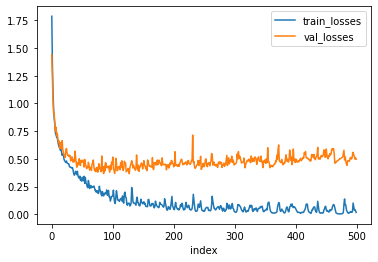

In [13]:
ax = train_vals.plot(x ='index', y='train_losses', kind = 'line')
train_vals.plot(x ='index', y='val_losses', kind = 'line', ax = ax)

<AxesSubplot:xlabel='index'>

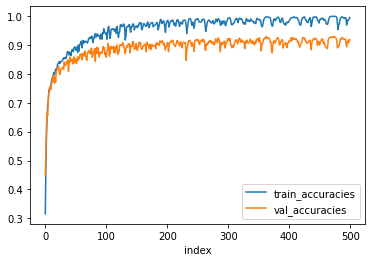

In [14]:
ax = train_vals.plot(x ='index', y='train_accuracies', kind = 'line')
train_vals.plot(x ='index', y='val_accuracies', kind = 'line', ax = ax)

# Confusion matrix

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import random


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: " + DEVICE)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.enabled = True

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

Using device: cuda


In [2]:
def read_data(file_path_X, file_path_y, seq_length):
    X_data = np.array(pd.read_csv(file_path_X, sep="\t", header=None, dtype=np.float32))
    y_data = np.array(pd.read_csv(file_path_y, sep="\t", header=None, dtype=np.int_))
    
    blocks = X_data.shape[0] / seq_length
    
    X_seq = np.array(np.split(X_data, blocks, axis=0))
    
    return X_seq, y_data

In [3]:
SEQ_LENGTH = 16

X_all, y_all = read_data("data/shortened_shuffled_poses.csv","data/shortened_shuffled_labels.csv", SEQ_LENGTH)
val_size = int(y_all.shape[0] * 0.2)
X_val, y_val = X_all[-val_size:], y_all[-val_size:]

In [4]:
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                             torch.tensor(y_val, dtype=torch.long).squeeze())

In [5]:
class LstmClassifier(nn.Module):
    
    def __init__(self, input_dim, n_classes, lstm_hidden_dim=256, fc_hidden_dim=256, n_lstm_layers=2):
        super(LstmClassifier, self).__init__()
        
        self._lstm = nn.LSTM(input_size=input_dim,
                             hidden_size=lstm_hidden_dim,
                             num_layers=n_lstm_layers,
                             batch_first=True)
        
        self._fc = nn.Sequential(nn.Linear(lstm_hidden_dim, fc_hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(fc_hidden_dim, n_classes))
        
    def forward(self, x):
        lstm_output, _ = self._lstm.forward(x)
        lstm_output = lstm_output[:, -1, :]
        fc_output = self._fc.forward(lstm_output)
        return fc_output

In [18]:
N_CLASSES = 8
INPUT_DIM = X_val.shape[2]
model = LstmClassifier(INPUT_DIM, N_CLASSES)
model = model.to(DEVICE)
model.load_state_dict(torch.load("lstm_action_classifier.pth.tar"))
val_batch_size = y_val.shape[0]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [38]:
def get_all_preds(model, batches):
    model.eval()
    all_preds = torch.tensor([]).to(DEVICE)
    correct_predictions = 0
    n_predictions = 0
    epoch_loss = 0.0


    for X_batch, y_batch in batches:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        with torch.no_grad():
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)

        epoch_loss += loss.item() * y_batch.shape[0]
        correct_predictions += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
        n_predictions += y_batch.shape[0]
        all_preds = torch.cat(
            (all_preds, torch.argmax(y_pred, dim=1))
            ,dim=0
        )
    
    epoch_loss = epoch_loss / n_predictions
    epoch_accuracy = correct_predictions / n_predictions
    
    return all_preds, epoch_loss, epoch_accuracy

In [40]:
val_batches = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, num_workers=4, shuffle=False)
all_preds, loss, accuracy = get_all_preds(model, val_batches)

In [57]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [100]:
cm = confusion_matrix(val_dataset.tensors[1], all_preds.cpu())
# cm = cm / len(val_dataset.tensors[1]) * 100
cm

array([[1009,   33,    1,    9,   34,   11,    6,    4],
       [  32,  698,    4,    2,   34,    7,    4,   10],
       [   3,    4,  251,    3,    4,    2,    0,    4],
       [   7,    4,    5,  354,    4,    0,    0,    0],
       [  39,   35,    1,    2,  966,    5,    1,   12],
       [  22,    7,    0,    0,    7,  253,    0,    3],
       [   5,    7,    0,    2,    5,    0,  230,    0],
       [   1,    9,    0,    1,    7,    1,    5,  270]])

In [103]:
cm.sum(axis=1)[:, np.newaxis]


array([[1107],
       [ 791],
       [ 271],
       [ 374],
       [1061],
       [ 292],
       [ 249],
       [ 294]])

In [108]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        title = "Normalized confusion matrix"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


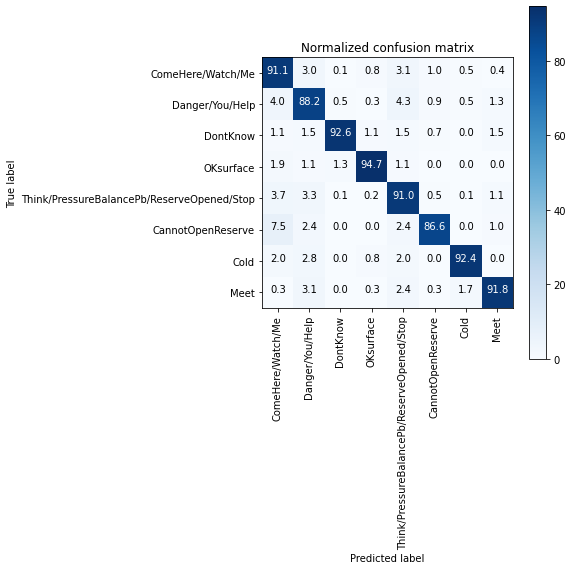

In [109]:
LABELS = ["ComeHere/Watch/Me",
          "Danger/You/Help",
          "DontKnow",
          "OKsurface",
          "Think/PressureBalancePb/ReserveOpened/Stop",
          "CannotOpenReserve",
          "Cold",
          "Meet"]

plt.figure(figsize=(N_CLASSES,N_CLASSES))
plot_confusion_matrix(cm, LABELS, normalize=True)